In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [4]:
from sklearn.decomposition import SparsePCA
import warnings
scaler_obj1=SparsePCA()
scaler_obj2=SparsePCA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)


X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
model1 = Sequential()
model1.add(keras.Input(shape=(1,5)))
model1.add(tf.keras.layers.LSTM(7,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros"))
model1.add(Dense(7))
model1.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model1.add(keras.layers.ReLU())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 364       
                                                                 
 dense (Dense)               (None, 7)                 56        
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7)                 0         
                                                                 
Total params: 448
Trainable params: 434
Non-trainable params: 14
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

In [8]:
model_fit8 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 70s 14ms/step - loss: 48.3531 - accuracy: 0.1801 - mse: 2251199744.0000 - mae: 95.7751 - rmse: 195.1606 - val_loss: -70.9563 - val_accuracy: 0.1780 - val_mse: 30178.1914 - val_mae: 72.2491 - val_rmse: 136.1617
Epoch 2/50
4563/4563 [==============================] - 61s 13ms/step - loss: 34.6853 - accuracy: 0.1780 - mse: 2251195392.0000 - mae: 95.7699 - rmse: 195.1596 - val_loss: -75.9412 - val_accuracy: 0.1765 - val_mse: 30178.1660 - val_mae: 72.2440 - val_rmse: 136.1614
Epoch 3/50
4563/4563 [==============================] - 61s 13ms/step - loss: -21.9541 - accuracy: 0.1682 - mse: 2251188480.0000 - mae: 95.7653 - rmse: 195.1591 - val_loss: -73.3002 - val_accuracy: 0.1691 - val_mse: 30178.0371 - val_mae: 72.2395 - val_rmse: 136.1607
Epoch 4/50
4563/4563 [==============================] - 60s 13ms/step - loss: 39.8865 - accuracy: 0.1622 - mse: 2251215616.0000 - mae: 95.7605 - rmse: 195.1577 - val_loss: -79.2530 - val_accuracy: 0.16

Epoch 32/50
4563/4563 [==============================] - 57s 12ms/step - loss: 38.8715 - accuracy: 0.0711 - mse: 2251206144.0000 - mae: 95.6914 - rmse: 195.1490 - val_loss: -91.9749 - val_accuracy: 0.0694 - val_mse: 30176.6348 - val_mae: 72.1676 - val_rmse: 136.1509
Epoch 33/50
4563/4563 [==============================] - 56s 12ms/step - loss: 40.5290 - accuracy: 0.0691 - mse: 2251216384.0000 - mae: 95.6912 - rmse: 195.1486 - val_loss: -92.2348 - val_accuracy: 0.0670 - val_mse: 30176.6270 - val_mae: 72.1673 - val_rmse: 136.1509
Epoch 34/50
4563/4563 [==============================] - 56s 12ms/step - loss: 49.5807 - accuracy: 0.0670 - mse: 2251197696.0000 - mae: 95.6909 - rmse: 195.1498 - val_loss: -92.3852 - val_accuracy: 0.0656 - val_mse: 30176.6270 - val_mae: 72.1669 - val_rmse: 136.1507
Epoch 35/50
4563/4563 [==============================] - 56s 12ms/step - loss: 32.6492 - accuracy: 0.0619 - mse: 2251205376.0000 - mae: 95.6909 - rmse: 195.1494 - val_loss: -92.8942 - val_accuracy: 0

In [9]:
model1.evaluate(x_test,y_test)

13518/13518 [==============================] - 107s 8ms/step - loss: -90.0814 - accuracy: 0.0722 - mse: 1403871.0000 - mae: 73.5423 - rmse: 139.6563


[-90.08136749267578,
 0.07220099121332169,
 1403871.0,
 73.54234313964844,
 139.65628051757812]

In [10]:
model1.evaluate(x_train,y_train)

40554/40554 [==============================] - 688s 16ms/step - loss: 30.5953 - accuracy: 0.0724 - mse: 2026011776.0000 - mae: 93.3302 - rmse: 189.2436


[30.595293045043945,
 0.07235806435346603,
 2026011776.0,
 93.3302230834961,
 189.24359130859375]

In [11]:
df1=pd.DataFrame(model_fit8.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(model_fit8.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(model_fit8.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,48.353092,-70.956337,0.180084,0.177955,2.251200e+09,30178.191406,95.775101,72.249084,195.160553,30178.191406
1,34.685322,-75.941185,0.177986,0.176532,2.251195e+09,30178.166016,95.769920,72.244026,195.159561,30178.166016
2,-21.954052,-73.300201,0.168163,0.169130,2.251188e+09,30178.037109,95.765312,72.239510,195.159134,30178.037109
3,39.886471,-79.253006,0.162185,0.162565,2.251216e+09,30177.898438,95.760468,72.234421,195.157669,30177.898438
4,42.843960,-80.292046,0.157786,0.162094,2.251205e+09,30177.904297,95.756920,72.232079,195.158340,30177.904297
5,38.934311,-80.614372,0.157062,0.161508,2.251215e+09,30177.822266,95.752968,72.227470,195.157242,30177.822266
6,29.396326,-81.296066,0.157012,0.161327,2.251196e+09,30177.765625,95.750542,72.224663,195.157898,30177.765625
7,39.808537,-83.114586,0.144644,0.121924,2.251214e+09,30177.617188,95.746101,72.220589,195.155884,30177.617188
8,43.130848,-83.459305,0.122142,0.120363,2.251193e+09,30177.580078,95.743340,72.217583,195.156311,30177.580078
9,38.221283,-83.529686,0.121038,0.120970,2.251199e+09,30177.568359,95.739578,72.214928,195.155411,30177.568359


In [12]:
df1.to_excel("LSTM.xlsx")

# Saving Model as File

In [13]:
print(x_test.shape)

(432571, 1, 5)


In [14]:
model_json = model1.to_json()
with open("lstm_tanh.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("lstm_tanh.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
from keras.models import model_from_json
json_file = open('lstm_tanh.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("lstm_tanh.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [16]:
print(loaded_model.history)

None


# Error Analysis

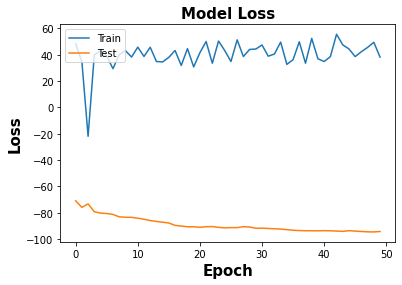

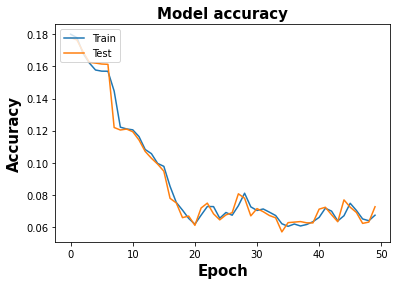

In [17]:
# summarize history for loss
plt.plot(model_fit8.history['loss'])
plt.plot(model_fit8.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_fit8.history['accuracy'])
plt.plot(model_fit8.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
#Creating csv file of prediction

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[0.7912938 , 0.        , 0.        , ..., 0.28287452, 0.01752815,
        0.        ],
       [0.7912938 , 0.        , 0.        , ..., 0.28287452, 0.01752815,
        0.        ],
       [0.7912938 , 0.        , 0.        , ..., 0.28287452, 0.01752815,
        0.        ],
       ...,
       [0.        , 0.8615177 , 0.6899148 , ..., 0.        , 0.        ,
        0.        ],
       [0.7912938 , 0.        , 0.        , ..., 0.28287452, 0.01752815,
        0.        ],
       [0.7912938 , 0.        , 0.        , ..., 0.28287452, 0.01752815,
        0.        ]], dtype=float32)

In [20]:
y_test

array([[[-5.4707150e+01,  3.0351229e+01,  2.6544733e+02, ...,
         -3.1806244e+01, -5.8596706e-01, -3.9942199e-01]],

       [[-4.0422195e+01, -3.2006611e+01,  3.9725319e+01, ...,
         -1.6595110e+01, -4.2555341e-01,  4.5112044e-01]],

       [[-5.2611900e+01,  6.3103738e+00, -5.3949774e+02, ...,
          2.1971800e+01,  4.6926007e+00,  9.8132938e-01]],

       ...,

       [[-8.7108231e+01, -3.0540722e+01, -4.3651901e+02, ...,
          6.8366714e+01,  3.2034805e-01,  1.0517381e+00]],

       [[-5.0692768e+01,  1.9452883e+01,  1.6842407e+02, ...,
         -2.2491724e+01, -1.5624888e+00,  2.1897414e-01]],

       [[-9.4654129e+01, -6.0080070e+01,  1.5260393e+02, ...,
         -2.9023485e+01, -8.3189094e-01, -4.2029378e-01]]], dtype=float32)

In [21]:
y_test=y_test[:,0]

In [22]:
from numpy import savetxt
savetxt('lstm_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [23]:
from numpy import savetxt
savetxt('lstm_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed